Copyright 2019 Intel Corporation

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Introduction

In Lesson 7 of *Anomaly Detection*, we discussed how to detect anomalies in time series using statistical process control and autoregressive models. Here we will apply both approaches to real-world datasets. 


# Learning Outcomes

You should walk away from this Python tutorial with:

1. An understanding of time series anomaly detection 
2. Practical experience with statistical process control and autoregressive models to detect anomalies in time series.



# Imports



In [1]:
# %matplotlib inline
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import sys
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import seaborn as sns
from scipy import stats
import statsmodels as ss
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

# Python and library versions

In [2]:
packages = [matplotlib, np, pd]

msg = f"""
Python Version: {sys.version}

library .      version
-------        -------"""
print(msg)

for package in packages:
    print(f"{package.__name__:11}    {package.__version__:>7}")


Python Version: 3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]

library .      version
-------        -------
matplotlib       3.1.0
numpy           1.16.4
pandas          0.24.2


# Section 1: Statistical process control

In this section, we are going to use statistical process control (SPC) to detect anomaly in time series. As we discussed in lectures, SPC provides quality control for time series data. 



### Data

As an example, we will use precipitation data for October 2018 for New York City (collected at JFK airport). The raw data is available from the NOAA website:

https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094789/detail

Here we provide a clean version of the data. We made two changes to the raw data: (1) the dates have been written in a format useful for time series analysis and (2) trace precipitation values have been replaced with zero.

In [3]:
df_ppt = pd.read_csv('nyc_precipitation_oct2018.csv', parse_dates=True, index_col=0)
df_ppt.head()

,Precipitation
Date,
2018-10-01,0.00
2018-10-02,0.33
2018-10-03,0.00
2018-10-04,0.04
2018-10-05,0.00


The precipitation is given in inches. 

See many days without precipitation and large values on October 11, 12 and 27. Visualize the data and summarize the statistics.

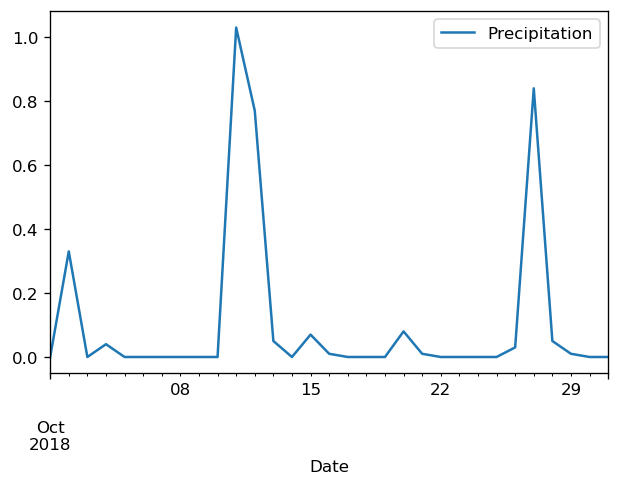

In [4]:
plt.figure(dpi=120)
df_ppt.plot(ax=plt.gca())
plt.show();

In [5]:
df_ppt.describe()

,Precipitation
count,31.000000
mean,0.107097
std,0.266573
min,0.000000
25%,0.000000
50%,0.000000
75%,0.045000
max,1.030000


Due to the many days without precipitation, the mean and standard deviation are fairly small, but the large maximum value suggest there is at least one anomalous point (October 11, 2018). 




### Control plot

We can see from the summary statistics and the plot that any anomalies will be above the mean, which is 0.107 in, so we need only a one-sided control plot.  

There is another way to reach the same conclusion. Since the precipitation cannot be a negative number, all possible values below the mean lie in the range 0 <= precipitation <= 0.107 in.), which are within one standard deviation (0.267 in.) of the mean and therefore not anomalies. 

Therefore, let's create a one-sided control plot.

In [6]:
def control_plot(time_series, threshold):
    '''
    Creates a one-sided control plot from a time series
    (that is, plots threshold above the mean but not below)
    Also, returns list of points that exceed the threshold
    i.e., points for which the value > mean + threshold*(standard deviation)
    
    Args: 
        time_series: (pandas dataframe; index column is date in datetime format and  
        column 0 is data)
        threshold: z-score threshold for anomaly detection (float)

    Returns: 
        Control plot of time_series    
        anomalies: anomalies that exceed threshold (pandas dataframe)
    ''' 
    
    mean_= time_series.iloc[:,0].mean()
    stdev_= time_series.iloc[:,0].std()
    cutoff = mean_+threshold*stdev_
    plt.figure(dpi=140)
    time_series.plot(ax=plt.gca())
    plt.axhline(y=mean_, color='g', linestyle='--', label='mean')
    # Use threshold to plot line at threshold*stdev_ times away from the mean
    plt.axhline(y=cutoff, color='r', linestyle=':', label='threshold')
    plt.legend(loc='best')
    plt.title('NYC October 2018 precipitation')
    plt.ylabel('Precipitation (in.)')
    
    # Create dataframe of anomalies that exceed the cutoff
    anomalies = time_series[time_series.values > cutoff]
    return anomalies

Set a threshold of 3 standard deviations and plot the results.

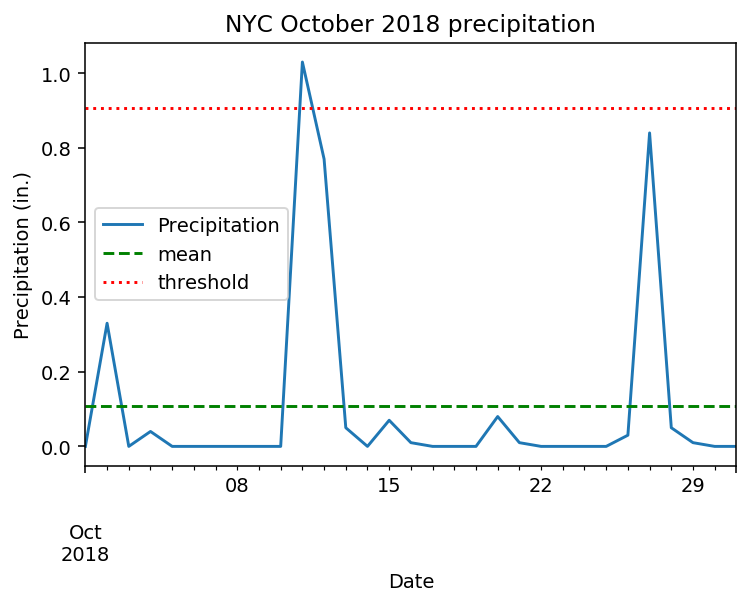

In [7]:
anomaly_ppt = control_plot(df_ppt, 3)

There's an anomaly. Get the data for this point. 

In [8]:
print(anomaly_ppt)

            Precipitation
Date                     
2018-10-11           1.03


This result agrees with our visual inspection. (For small datasets, humans are good at detecting statistical patterns, such as outliers, by eye.)

### Cumulative sum (CUSUM)

For comparison, let's apply the CUSUM approach and see what we find. We will use the algorithm outlines in the lecture.

In [9]:
def cusum(data, mean, shift, threshold):
    '''
    Calculate the high and low cumulative sums and use these for anomaly detection. 
    An anomaly is reported if the cumulative sums are beyong a given threshold.
    
    Args: 
        data: (a time series as pandas dataframe; index column is date in datetime format and  
        column 0 is data)
        mean:  mean of the data or other average (float)
        shift: normal shift in the data; standard deviation is recommend (float)
        threshold: threshold to classify point as anomaly (float)

    Returns: 
        cusum: the high and low cumulative sums together with data (pandas dataframe)  
        anomalies: anomalies that above and below threshold (pandas dataframe)
    ''' 
    high_sum = 0.0
    low_sum = 0.0
    anomalies = [] 
    high_sum_final = []
    low_sum_final = []
    index_names = data.index
    data_values = data.values
    for index, item in enumerate(data_values):
        high_sum = max(0, high_sum + item - mean - shift)
        low_sum = min(0, low_sum + item - mean + shift)
        high_sum_final.append(high_sum)
        low_sum_final.append(low_sum)
        if high_sum > threshold or low_sum < -threshold:
            anomalies.append((index_names[index], item.tolist()))
    cusum = data
    cusum = cusum.assign(High_Cusum=high_sum_final, Low_Cusum=low_sum_final)
    return cusum, anomalies

And we will also plot the results of our CUSUM analysis.

In [10]:
def cusum_plot(time_series, threshold):
    '''
    Plot the high and low cumulative sums and use these for anomaly detection. 
    An anomaly is reported if the cumulative sums are beyong a given threshold.
    
    Args: 
        time_series: (a time series as pandas dataframe; index column is date 
        in datetime format and column 0 is data)
        threshold: threshold to classify point as anomaly (float)

    Returns: 
        A plot of the data with the high cumulative sum.
        cusum_results: the high and low cumulative sums together with data 
        and any anomalies that above and below threshold (pandas dataframe; 
        from cumsum function)
    ''' 
    # Use the mean and standard deviation of the whole time series 
    # to calculate cumulative sums
    mean_= time_series.iloc[:,0].mean()
    stdev_= time_series.iloc[:,0].std()
    
    # define threshold in terms of standard deviation
    cusum_results = cusum(time_series, mean_, stdev_, threshold*stdev_)
    ax=time_series.plot()
    ax.axhline(y=mean_, color='g', linestyle='--',label='average')
    ax.axhline(y=mean_+threshold*stdev_, color='r', linestyle='--',label='High threshold')
    # Use threshold to plot line at threshold*stdev_ times away from the mean
    ax.scatter(x=cusum_results[0].index, y=cusum_results[0]['High_Cusum'], 
             color='k', linestyle=':',label='High Cusum')                      
    plt.legend(loc='center left')
    plt.title('NYC October 2018 precipitation')
    plt.ylabel('Precipitation (in.)')
    plt.gcf().set_size_inches(8,6)
    plt.show()
    
    return cusum_results

Choice of threshold: for the control chart, we used 3 times the standard deviation. Note that the equivalent threshold for CUSUM is *threshold*=2 since CUSUM includes the *shift* (which we chose to be one standard deviation) in its calculation of the cumulative sum. 

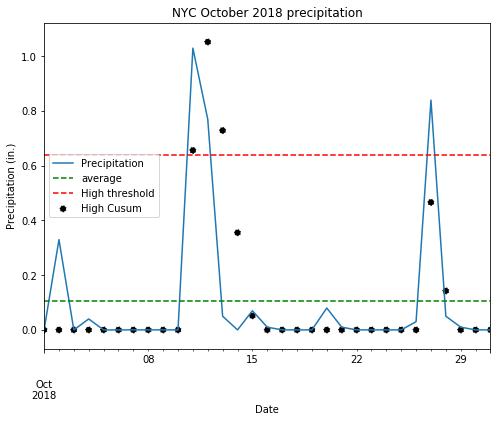

In [11]:
cusum_plot(df_ppt, 2);

Note that CUSUM finds the same anomaly as the control chart (1.03 inches on October 11, 2018), but it also labels the two successive points as anomalies. Why? 

The different results reflect the difference in the algorithms. The control chart is looking for single, anomalous points. CUSUM is sensitive to change in the behavior of the data. As a result, it flags points as anomalous until the behavior of the time series has returned to normal. 

Indeed, CUSUM is used for change point detection: finding when the underlying distribution of the time series has changed. 


**A final comment.**  We used all of the data to compute the baseline statistics (mean and standard deviation) for the anomaly detection. While this approach is sometimes used, the presence of anomalies in the data can bias these baseline statistics. A more rigorous approach is to select data that is considered normal, use that data to calculate the baseline statistics and only then detect the anomalies.  We will explore this idea in Exercise 1.

# Section 2: Autogressive models

So far, we carried out analysis in offline mode---we had all of the data of interest at hand. As a result, when examining any given point, we could use both the past and the future (with respect to that point) to calculate statistics such as the mean and standard deviation.

Often, we are interested in analyzing time series in streaming mode---that is, as the data becomes available. In this case, any models we use to detect anomalies can only use the past (with respect to a given point). Future data is not available. 

As discussed in lectures, autoregressive models are commonly used for streaming anomaly detection and we will examine one such model below. 

### Data

We will use another weather dataset from New York City (collected at JFK airport): maximum and minimum daily temperatures from February 1, 1959 to October 31, 2018. 

The raw data is available from the NOAA website we used:

https://www.ncdc.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094789/detail

Here we provide a clean version of the data. We processed the raw data as follows: (1) the dates have been written in a format useful for time series analysis and (2) two missing values have been filled in.

The two dates that had no values (for either the maximum or minimum temperature) were Dec. 1, 1959 and May 1, 1960. For the purposes of this notebook, we added anomalous values to these dates as shown below. (If we weren't studying anomaly detection, we would have added values corresponding to the mean temperatures of the day before and day after to avoid gaps in the time series.)

In [12]:
df_nyc_temp = pd.read_csv('nyc_daily_temp_final.csv', parse_dates=True, index_col=0)

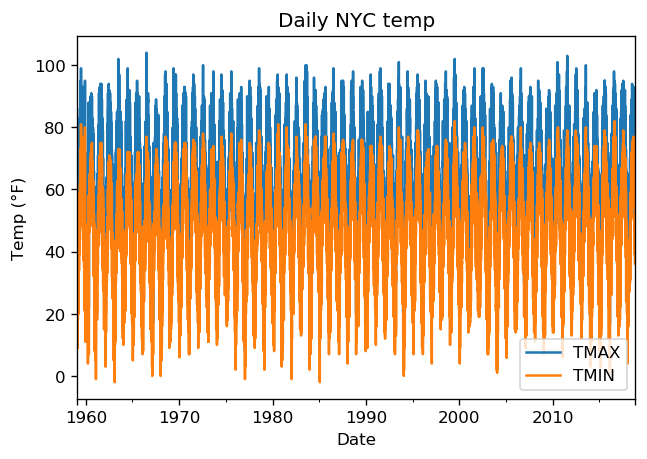

In [13]:
plt.figure(dpi=120)
df_nyc_temp.plot(ax=plt.gca())
plt.title('Daily NYC temp')
plt.xlabel('Date')
plt.ylabel('Temp (°F)')
plt.show()


Not easy to see whether there are anomalies with so many points. Let's look at the statistics for both TMAX (the maximum daily temperature) and TMIN (the minimum daily temperature). 

In [14]:
df_nyc_temp.describe()

,TMAX,TMIN
count,21823.000000,21823.000000
mean,61.548091,47.129496
std,17.585690,16.468738
min,8.000000,-2.000000
25%,48.000000,34.000000
50%,62.000000,47.000000
75%,77.000000,62.000000
max,104.000000,82.000000


The highest value of TMAX (104 °F) and the lowest value of TMIN (-2 °F) are quite extreme. But are these anomalies?

And what about the anomalies we seeded into the dates with missing values?

For Dec. 1, 1959, TMAX and TMIN are 40 °F *warmer* than what a linear interpolation would predict.

In [15]:
df_nyc_temp.loc['1959-11-30':'1959-12-02']

,TMAX,TMIN
DATE,,
1959-11-30,38,26
1959-12-01,95,80
1959-12-02,51,33


For May 1, 1960, TMAX and TMIN are 40°F *colder* than what a linear interpolation would predict.

In [16]:
df_nyc_temp.loc['1960-4-30':'1960-5-02']

,TMAX,TMIN
DATE,,
1960-04-30,60,50
1960-05-01,22,7
1960-05-02,64,43


Will we detect these points as anomalies?

### Modeling

We will use an autoregressive model to detect anomalies. Here we will look at TMAX and leave TMIN for Exercise 2. 

We start by creating a dataframe of just TMAX

In [17]:
df_nyc_tmax=df_nyc_temp[['TMAX']]

Check that the new dataframe is as expected.

In [18]:
df_nyc_tmax.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21823 entries, 1959-02-01 to 2018-10-31
Data columns (total 1 columns):
TMAX    21823 non-null int64
dtypes: int64(1)
memory usage: 981.0 KB


In [19]:
df_nyc_tmax.head()

,TMAX
DATE,
1959-02-01,24
1959-02-02,26
1959-02-03,38
1959-02-04,44
1959-02-05,46


As a baseline for the autoregression model, we can check what a control plot reveals as anomalies. In contrast to the precipitation example, here we can have anomalies on either side of the mean, so we modify *control_plot* to become a full, two-sided control plot. 

In [20]:
def control_plot_full(time_series, threshold):
    '''
    Creates a two-sided control plot from a time series
    (plots threshold above and below the mean)
    Also, returns list of points that exceed the threshold
    i.e., points for which the value > mean + threshold*(standard deviation) 
    and value < mean - threshold*(standard deviation)
    
    Args: 
        time_series: (pandas dataframe; index column is date in datetime format and  
        column 0 is data)
        threshold: threshold for anomaly detection (float)

    Returns: 
        Control plot of time_series    
        anomalies: anomalies that exceed threshold (pandas dataframe)
    ''' 
    
    mean_= time_series.iloc[:, 0].mean()
    stdev_= time_series.iloc[:, 0].std()
    time_series.plot()
    plt.axhline(y=mean_, color='g', linestyle='--',label='average')
    # Use threshold to plot line at threshold*stdev_ times away from the mean
    plt.axhline(y=mean_+threshold*stdev_, color='r', linestyle=':', label='high threshold')
    plt.axhline(y=mean_-threshold*stdev_, color='m', linestyle=':', label='low threshold')
    plt.legend(loc='upper right')
    plt.title('NYC Temperature')
    plt.ylabel('Temp (F)')
    plt.gcf().set_size_inches(8,6)
    plt.show()
    
    # Create dataframe of anomalies that exceed the threshold
    anomaly_mask = (np.abs(time_series.values - mean_) > threshold*stdev_)
    anomalies = time_series[anomaly_mask]
    return anomalies

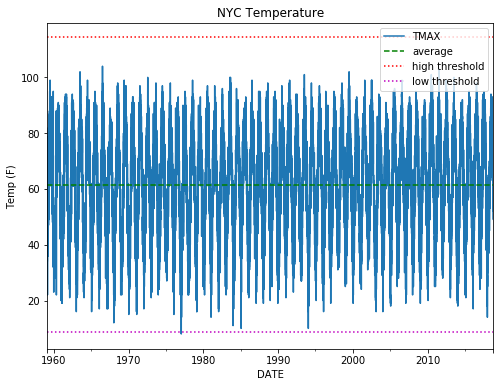

,TMAX
DATE,
1977-01-17,8


In [21]:
control_plot_full(df_nyc_tmax, 3)

We find only one anomaly: the minimum of TMAX. 

On to our autoregression model. An overview of such models (with references for further study) is given in the lecture; a detailed discussion goes beyond the scope of the lessons on anomaly detection. 

**Note_1**: It can take a significant amount of work to find a successful autoregression model and we do not claim that the model presented here is optimal.The parameters were chosen to have a reasonable runtime.

**Note_2**: There are models that explicit incorporate _seasonal effects_ while modeling, such as the statsmodels SARIMAX function. The length of a full cycle cannot be too long for the series to converge, so yearly seasons don't work well on daily data (each season is 365 data points). A more sophisticated treatment, such as doing a Fourier Analysis and then subtracting off the annual component would typically be done in this case. 

**Note_3**: The autoregression models in python require that the time series analyzed have an appropriate date frequency, which is why it is important to check for missing values as a pre-processing step. If the time_series is complete, many packages that deal with time_series can infer the frequency, even if it isn't supplied.

In [22]:
print(df_nyc_tmax.index.inferred_freq)

D


Daily frequency. That's good! Let's make it explicit!

In [23]:
df_nyc_temp.index.freq=df_nyc_tmax.index.inferred_freq

And now to fit our data with the model.

In [24]:
tmax_sar=ARIMA(df_nyc_tmax, order=(1,1,4)).fit()

tmax_sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                 D.TMAX   No. Observations:                21822
Model:                 ARIMA(1, 1, 4)   Log Likelihood              -71865.149
Method:                       css-mle   S.D. of innovations              6.516
Date:                Thu, 16 Jan 2020   AIC                         143744.298
Time:                        14:30:07   BIC                         143800.233
Sample:                    02-02-1959   HQIC                        143762.521
                         - 10-31-2018                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0011      0.011      0.094      0.925      -0.021       0.023
ar.L1.D.TMAX     0.0863      0.121      0.715      0.475      -0.150       0.323
ma.L1.D.TMAX    -0.4539      0.120     -3.768      0.000      -0.690      -0.218
ma.L2.D.TMAX    -0.2282      0.045     -5.037      0.000      -0.317      -0.139
ma.L3.D.TMAX    -0.0530      0.033     -1.585      0.113      -0.118       0.013
ma.L4.D.TMAX    -0.0311      0.013     -2.350      0.019      -0.057      -0.005
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           11.5940           +0.0000j           11.5940            0.0000
MA.1            1.1796           -0.0000j            1.1796           -0.0000
MA.2           -2.6773           -0.0000j            2.6773           -0.5000
MA.3           -0.1038           -3.1911j            3.1928           -0.2552
MA.4           -0.1038           +3.1911j            3.1928            0.2552
-----------------------------------------------------------------------------
"""

We will not discuss the statistics reported, except to say that it includes the standard deviation of the residuals (6.516), which we will use later.

We check the diagnostics to check that the assumptions underlying the model are met and also for additional information on the quality of the fit.  This is done using a Q-Q plot (checking that the residuals follow a normal distribution), investigating the residuals for temporal patterns, and plotting a histogram of the residuals

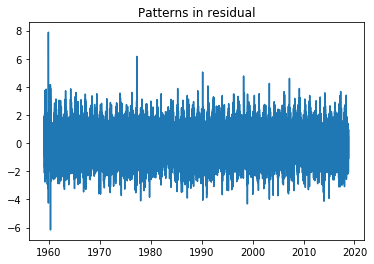

In [25]:
# Get the predicted standard deviation. This is the 6.516 we saw earlier
sigma_pred = tmax_sar.resid.std()
# Calculate the standardized residuals from the (regular) residuals
tmax_std_resid = tmax_sar.resid/sigma_pred

plt.title('Patterns in residual')
plt.plot(tmax_std_resid);

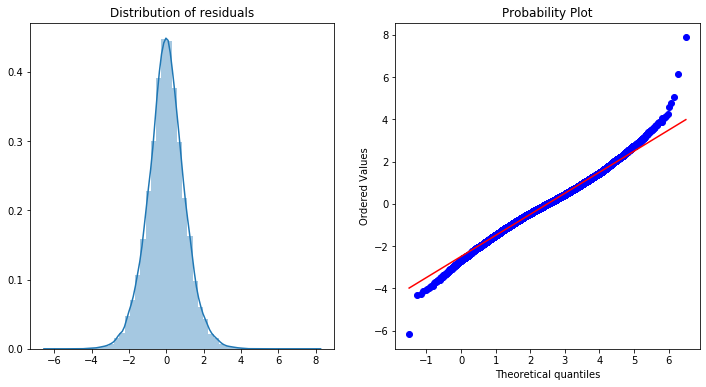

In [26]:
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(121)
plt.title('Distribution of residuals')
sns.distplot(tmax_std_resid.values, bins=50, ax=ax);
stats.probplot(tmax_std_resid.values, dist='norm', sparams=(2.5,), plot=plt.subplot(122));

For anomaly detection, we focus on the top plot: standardized residuals. The standardized residual is the residual (the difference between the observed value and the predicted value) divided by the predicted standard deviation (the square root of the predicted variance we mentioned above). It is a more sophisticated version of the z-score we discussed in Lesson 1.

A rule of thumb for detecting anomalies with standardized residuals: anomalies are points for which the magnitude of the standardized residals is greater than 4. Let's find these points. 

In [27]:
# Report the anomalies
anomaly_mask = np.abs(tmax_std_resid) > 4
tmax_anomalies = tmax_std_resid[anomaly_mask]
print(tmax_anomalies)

DATE
1959-12-01    7.880269
1959-12-02   -4.253221
1960-03-28    4.139774
1960-04-25    4.132755
1960-05-01   -6.163637
1977-04-12    6.163847
1978-01-10   -4.098254
1990-03-13    5.051013
1990-03-24   -4.054001
1991-03-28    4.064880
1998-03-27    4.770966
1998-03-29    4.052428
1998-12-23   -4.314462
2003-04-16    4.244705
2007-03-27    4.598869
2014-01-07   -4.122699
dtype: float64


Our model found both of the seeded anomalies (Dec. 1, 1959 and May 1, 1960). 

The model did not find the lone anomaly detected by the control plot (January 17, 1977), but it did find several others that were not picked up by the control plot. 

The next step would be to vary the parameters of the autoregression model and check how robust these findings are, but as that belongs to the realm of time series analysis, we will stop here.

### Exercise #1

This exercise refers to Section 1 (statistical process control). 

A. Choose a subset of the precipitation data that you consider anomaly-free (for example, the first 10 days). Use this data to calculate the mean and standard deviation.

B. Repeat the control chart analysis.

C. Compare the anomalies you find with those found previously.

### Solution #1

In [28]:
# YOUR CODE HERE

### Exercise #2

This exercise refers to Section 2 (autogression models). 

A. Repeat the analysis for the TMIN values. 

B. Do you find the same anomalies as TMAX?

### Solution #2



In [29]:
# YOUR CODE HERE

# Summary

In this assignment you should have learned: 

1. An understanding of time series anomaly detection 
2. Practical experience with statistical process control and autoregressive models to detect anomalies in streaming data.

Congratulations! This concludes the lesson.

In [30]:
print('end')

end
